In [54]:
import sys
sys.path.append("./../../src")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
from torch import nn, optim
import pickle

from vae_with_dataloader import VAE, VAETrainerWithDataLoader
# from icd_analysis_helper import ICDAnalysisHelper
from dataloader import MixehrICDImputationDataset
from visualizer_helper import Visualizer

from config_reader import Config
import os
import math
from sklearn.model_selection import train_test_split

visualizer = Visualizer()

In [93]:
config = Config('./config.ini', date="200211")
experiment_name=config.experiment_name
config.__dict__

local_icd_path = "/Users/andrew/Documents/meng/mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv.gz"
local_patient_path = "/Users/andrew/Documents/meng/spring/PATIENT_ICD_BINARY.csv"
patient_csr_path = "/Users/andrew/Documents/meng/spring/PATIENT_ICD_BINARY_SPARSE_CSR.p"
patient_csc_path = "/Users/andrew/Documents/meng/spring/PATIENT_ICD_BINARY_SPARSE_CSC.p"

subject_ids = pd.read_csv("/Users/andrew/Documents/meng/spring/PATIENT_ICD_SUBJECT_IDS.csv")

yue_admissions_path = "/Users/andrew/Documents/meng/mixEHR/data/Mimic/version_1_3/ADMISSIONS.csv.gz"
yue_df = pd.read_csv(yue_admissions_path)
yue_patient_visits = yue_df.SUBJECT_ID.value_counts()
yue_patient_idxs = yue_patient_visits[yue_patient_visits == 1].index
single_adm_patient_idxs = subject_ids[subject_ids.SUBJECT_ID.isin(yue_patient_idxs)].index
single_adm_patient_idxs

Int64Index([    2,     3,     4,     5,     7,     8,     9,    10,    11,
               13,
            ...
            46509, 46510, 46511, 46512, 46513, 46514, 46515, 46516, 46518,
            46519],
           dtype='int64', length=38983)

In [97]:
icd9codes = pd.read_csv(local_icd_path)
icd_columns = pd.read_csv("PATIENT_ICD_ICD9_CODES.csv")

patient_csr = pickle.load(open(patient_csr_path, "rb"))
yue_patient_csr = patient_csr[single_adm_patient_idxs]
patient_csc = pickle.load(open(patient_csc_path, "rb"))
yue_patient_csc = patient_csc[single_adm_patient_idxs]
yue_patient_csc

<38983x6984 sparse matrix of type '<class 'numpy.int64'>'
	with 390685 stored elements in Compressed Sparse Column format>

In [101]:
icd_cols_list = np.squeeze(icd_columns.as_matrix(), axis=1).tolist()
icd_freqs = np.array(yue_patient_csc.sum(axis=0))[0].tolist()

icd_label_freqs = zip(icd_cols_list, icd_freqs)

top_icd_pairs = sorted(icd_label_freqs, key=lambda pair: pair[1], reverse=True)

k = 10 
top_k_pairs = top_icd_pairs[:k]
print(top_k_pairs)

top_k_icds = [p[0] for p in top_k_pairs]
top_k_freqs = [p[1] for p in top_k_pairs]

[('4019', 13516), ('41401', 8246), ('42731', 7603), ('4280', 6523), ('V053', 5605), ('2724', 5430), ('V290', 5399), ('25000', 5319), ('5849', 4801), ('51881', 4416)]


/opt/anaconda3/envs/mengp369/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [115]:
top_k_icd_info = icd9codes[icd9codes.ICD9_CODE.isin(top_k_icds)]
top_k_icd_info

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
1588,1591,25000,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...
2390,2747,2724,Hyperlipidemia NEC/NOS,Other and unspecified hyperlipidemia
4303,4304,4019,Hypertension NOS,Unspecified essential hypertension
4373,4374,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
4461,4462,42731,Atrial fibrillation,Atrial fibrillation
4472,4473,4280,CHF NOS,"Congestive heart failure, unspecified"
5550,5279,51881,Acute respiratry failure,Acute respiratory failure
5906,5908,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
10952,13688,V290,NB obsrv suspct infect,Observation for suspected infectious condition
13229,12202,V053,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...


In [103]:
tidx = icd_columns[icd_columns.ICD9_CODE == '25000'].index[0]
print(patient_csc[:, tidx].nonzero()[0].tolist())

[6, 11, 18, 23, 38, 45, 78, 83, 84, 87, 91, 97, 99, 114, 130, 146, 148, 150, 153, 160, 166, 177, 181, 192, 200, 216, 239, 241, 242, 255, 266, 269, 278, 287, 301, 325, 327, 329, 342, 366, 367, 368, 371, 375, 380, 382, 388, 401, 427, 439, 442, 461, 462, 468, 470, 473, 476, 487, 494, 495, 507, 516, 541, 542, 546, 549, 550, 557, 568, 575, 584, 596, 601, 602, 603, 607, 631, 650, 658, 665, 669, 677, 702, 704, 713, 722, 742, 749, 764, 769, 773, 777, 782, 789, 794, 795, 799, 815, 835, 841, 844, 858, 866, 873, 874, 885, 906, 910, 913, 917, 933, 943, 947, 949, 953, 960, 979, 992, 995, 1004, 1007, 1010, 1011, 1014, 1015, 1021, 1027, 1041, 1059, 1068, 1072, 1073, 1075, 1081, 1099, 1100, 1105, 1109, 1120, 1124, 1125, 1128, 1130, 1131, 1135, 1158, 1168, 1177, 1189, 1190, 1193, 1205, 1208, 1215, 1223, 1225, 1231, 1244, 1250, 1264, 1267, 1269, 1299, 1301, 1310, 1314, 1317, 1319, 1331, 1338, 1341, 1353, 1369, 1384, 1394, 1398, 1403, 1409, 1410, 1421, 1425, 1429, 1465, 1466, 1469, 1475, 1477, 1478, 1479

In [109]:
patients_with_top_k = []
for icd in top_k_icds:
    icd_idx = icd_columns[icd_columns.ICD9_CODE == icd].index[0]
    patients_with_icd = np.clip(yue_patient_csc[:, icd_idx].nonzero()[0], None, 38070)
    print(len(patients_with_icd))
    patients_with_top_k.append((icd, patients_with_icd))
    


13516
8246
7603
6523
5605
5430
5399
5319
4801
4416


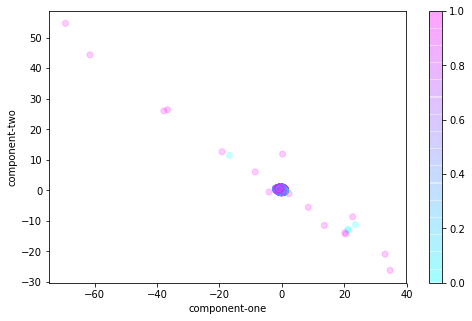

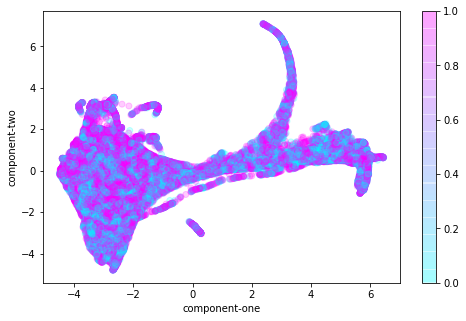

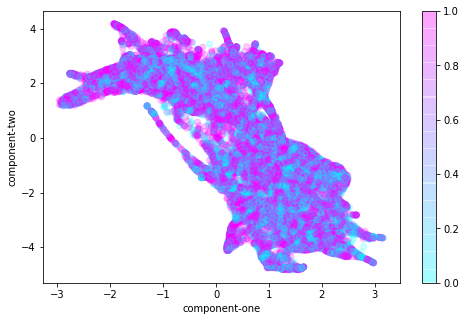

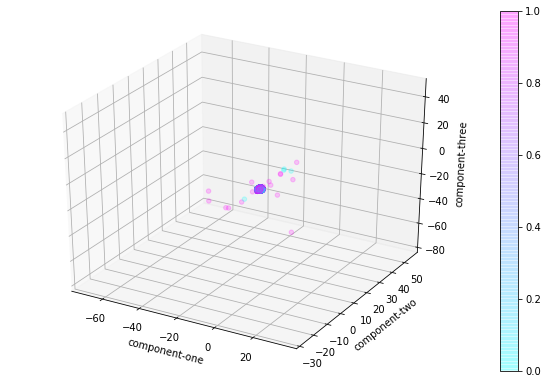

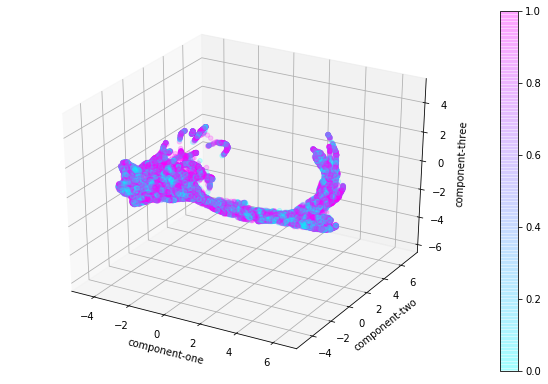

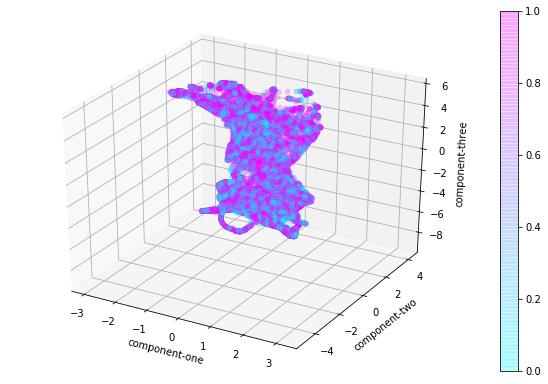

In [114]:
###Encode and plot 3d Data
epoch=10
X_umap_3d = pickle.load(open("X_umap_3d.p", 'rb'))
mean_umap_3d = pickle.load(open("mean_umap_3d.p", 'rb'))
var_umap_3d = pickle.load(open("var_umap_3d.p", 'rb'))

icd_idx_of_interest = 0
icd_test = patients_with_top_k[icd_idx_of_interest][0]
patient_subset = patients_with_top_k[icd_idx_of_interest][1]

alpha3d = 0.2
colors = np.array([1 for i in range(X_umap_3d.shape[0])])
colors[patient_subset] = 0
cohort = "everyone_vs_icd_{}".format(icd_test)


visualizer.plot2d(
    X=X_umap_3d[:, :-1], 
    filename="Patient_Clusters_2D_exp_{}_epoch_{}_{}".format(experiment_name, epoch, cohort, "_from_3d"), 
    colors=colors,
    alpha = alpha3d
)

visualizer.plot2d(
    X=mean_umap_3d[:, :-1], 
    filename="Patient_Clusters_2D_exp_{}_epoch_{}{}".format(experiment_name, epoch, cohort, "__means_from_3d"), 
    colors=colors,
    alpha = alpha3d
)

visualizer.plot2d(
    X=var_umap_3d[:, :-1], 
    filename="Patient_Clusters_2D_exp_{}_epoch_{}{}".format(experiment_name, epoch, cohort, "_vars_from_3d"), 
    colors=colors,
    alpha = alpha3d
)

visualizer.plot3d(
    X=X_umap_3d, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, cohort, ""), 
    colors=colors,
    alpha = alpha3d
)

visualizer.plot3d(
    X=mean_umap_3d, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, cohort, "_means"), 
    colors=colors,
    alpha = alpha3d
)

visualizer.plot3d(
    X=var_umap_3d, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, cohort, "_vars"), 
    colors=colors,
    alpha = alpha3d
)